# Guide experimental studies - receptor (in)activation of the uOR 

This notebook provides a step-by-step guide to replicate the analysis outlined in the section, "Guide experimental studies - receptor (in)activation of the uOR " Follow along to explore the protocol used to identify atoms with significant differences between active and inactive-like protein structures, using Molecular Dynamics (MD) simulations and Chemical Shift (CS) predictors.

### Load modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PDB_small
from MDAnalysis.analysis import rms, align, distances, contacts, dihedrals

from scipy import stats

import statistics

import math

import nglview as nv

### Load Functions

In [1]:
# Create a mapping function to scale p-values using -log10
def scale_pvalue(pvalue, min_value):
    # Check if the p-value is exactly 0
    if pvalue == 0:
        # Handle p-value of 0 by returning the negative logarithm of the minimum non-zero p-value
        return -math.log10(min_value)
    # For non-zero p-values, calculate the negative logarithm
    return -math.log10(pvalue)

def map_to_range(value, min_value, max_value):
    # Ensure the value is within the range [min_value, max_value]
    value = max(min(value, max_value), min_value)
    
    # Calculate the mapped value within the range 
    mapped_value = max_bfactor * (value - min_value) / (max_value - min_value)
    
    return round(mapped_value, 2)  # Round to two decimal places

%matplotlib inline

### Reading MD Frames and Setting Up Reference Files

In this section, we read Molecular Dynamics (MD) frames from the specified PDB and XTC files and set up reference structures for the inactive and active states. These reference structures will be used for comparisons during the analysis to identify key differences between active and inactive conformations of the protein.

- **`PDB`**: Path to the protein structure file.
- **`XTC`**: Path to the MD trajectory file.
- **`ref_inactive`**: Universe object representing the reference structure for the inactive state.
- **`ref_active`**: Universe object representing the reference structure for the active state.
- **`atom_type`**: Atom to evaluate. Follow the PDB atom type codes.
- **`output_pdb_pvalues`**: Path to the protein output structure, where PValues will be reflected as BFactors.
- **`output_pdb_diffmeans`**: Path to the protein output structure, where difference in mean CS will be reflected as BFactors.

Ensure that the paths to your MD trajectory and reference structure files are correctly specified before running this code.

In [2]:
# Define File Paths and Load Reference Structures
PDB = "MDs/protein.pdb"
XTC = "MDs/protein_traj.dcd"

# Load Reference Structures for Inactive and Active States
ref_inactive = mda.Universe('ReferenceFrames/reference_inactive_BB.pdb') #Backbone PDB: 4DKL
ref_active = mda.Universe('ReferenceFrames/reference_active_BB.pdb')     #Backbone PDB: 5C1M

# Atom type to analyze
atom_type = 'N'

# Max Value for Scaled P-Values as Beta-Factors
max_bfactor = 40

# Output PDB file with the mapped P-values as Beta-Factors
output_pdb_pvalues = 'N_40_pvalue.pdb'
output_pdb_diffmeans = 'N_40_diffmean.pdb'

### Loading Files and Creating an Average Structure

In this section, we load the Molecular Dynamics (MD) trajectory and protein structure files specified by `PDB` and `XTC`. We also create an average structure from the trajectory for later use. Here's a breakdown of the actions:

- **`u`**: Universe object representing the MD trajectory and structure.
- **`average`**: Calculation of an average structure using the `align.AverageStructure` function. This average structure will be used as a reference.
- **`ref`**: Universe object representing the reference structure derived from the average.

Additionally, we align the MD trajectory to the reference structure to ensure that subsequent analyses are performed with respect to this reference. The `align.AlignTraj` function is employed for this purpose, aligning the trajectory to the reference structure based on the selection of protein alpha carbon atoms (CA).


In [3]:
# Create a Universe object 'u' to load the protein structure (PDB) and trajectory (XTC) files.
u = mda.Universe(PDB, XTC)

# Generate an average structure using the alpha carbon atoms ('name CA') of the protein.
# This average structure will serve as a reference for alignment.
average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=0).run()

# Get the reference universe ('ref') from the generated average structure.
ref = average.universe

# Align the entire trajectory ('u') to the reference structure ('ref').
# This alignment is performed based on the alpha carbon atoms of the protein.
# Use in-memory computation for efficiency.
aligner = align.AlignTraj(u, ref, select='protein and name CA', in_memory=True).run()

/opt/miniconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/align.py:950: DeprecationWarning: The `universe` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.universe` instead.
  warnings.warn(wmsg, DeprecationWarning)


### Calculating RMSD for Inactive Conformation

In this section, we calculate the Root Mean Square Deviation (RMSD) for the protein's inactive conformation with respect to the reference structure. The following steps are performed:

- **`R_inact`**: We initialize an RMSD analysis using MDAnalysis to calculate the RMSD for the specified selection of residues (residues 66-346) and backbone atoms. This analysis is conducted for each frame in the trajectory.

- **`df_inact`**: The RMSD values calculated for each frame are stored in a Pandas DataFrame for further analysis. This DataFrame includes information about the frame number, time, RMSD of the backbone, and RMSD of the transmembrane region (TM6).

- **`rmsd` and `time`**: We transpose the DataFrame to facilitate plotting, extracting RMSD values and time information for visualization.

- Finally, a plot is generated to visualize the RMSD of the inactive conformation over the course of the simulation.


/opt/miniconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)
/opt/miniconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


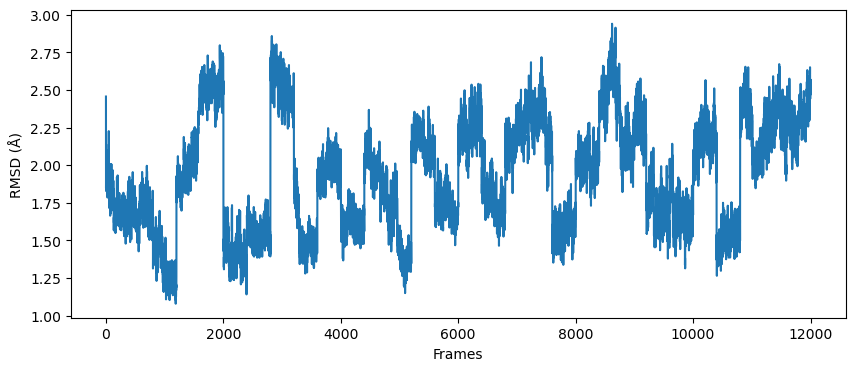

In [4]:
# Create an RMSD analysis object 'R_inact' to calculate RMSD values.
# The analysis is performed on the specified residues (resid 66 to 258 and 273 to 346) and backbone atoms.
# Additional group selections are applied to isolate the transmembrane region (TM6).
R_inact = mda.analysis.rms.RMSD(u, ref_inactive,
                                       select='resid 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 175 176 177 178 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 228 229 230 231 232 233 234 235 236 237 238 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 258 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 327 328 329 330 331 332 333 334 335 336 337 338 339 341 342 343 344 345 346 and backbone',
                                       groupselections=["backbone and (resid 273 to 305)",])
R_inact.run()

# Create a Pandas DataFrame 'df_inact' to store the RMSD data.
df_inact = pd.DataFrame(R_inact.rmsd, columns=['Frame', 'Time', 'Backbone', 'TM6'])

# Transpose the RMSD data for easier plotting.
rmsd = R_inact.rmsd.T
time = rmsd[0]

# Create a figure for visualization.
fig = plt.figure(figsize=(10, 4))

# Customize plot labels and attributes.
plt.ylabel('RMSD (Å)')
plt.xlabel('Frames')

# Plot RMSD values for the transmembrane region (TM6) over time.
plt.plot(time, rmsd[2])

### Calculating RMSD for Active Conformation

In this section, we calculate the Root Mean Square Deviation (RMSD) for the protein's active conformation with respect to the reference structure. The following steps are performed:

- **`R_act`**: We initialize an RMSD analysis using MDAnalysis to calculate the RMSD for the specified selection of residues (residues 66-346) and backbone atoms. This analysis is conducted for each frame in the trajectory.

- **`df_act`**: The RMSD values calculated for each frame are stored in a Pandas DataFrame for further analysis. This DataFrame includes information about the frame number, time, RMSD of the backbone, and RMSD of the transmembrane region (TM6).

- **`rmsd` and `time`**: We transpose the DataFrame to facilitate plotting, extracting RMSD values and time information for visualization.

- Finally, a plot is generated to visualize the RMSD of the inactive conformation over the course of the simulation.

/opt/miniconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


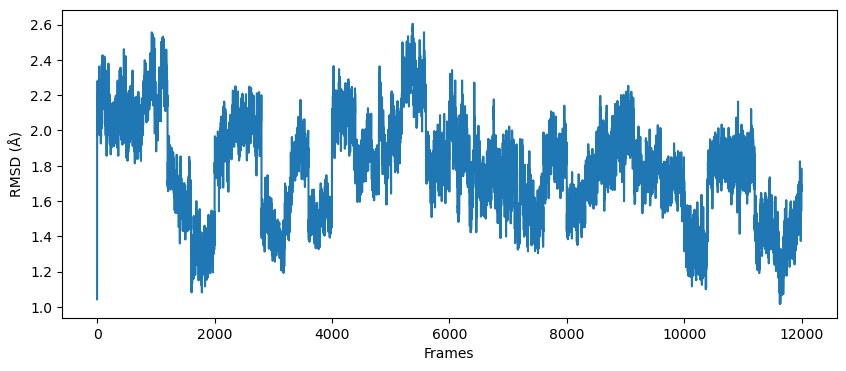

In [5]:
# Create an RMSD analysis object 'R_act' to calculate RMSD values.
# The analysis is performed on the specified residues (resid 66 to 258 and 273 to 346) and backbone atoms.
# Additional group selections are applied to isolate the transmembrane region (TM6).
R_act = mda.analysis.rms.RMSD(u, ref_active,
                                      select='resid 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 175 176 177 178 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 and backbone',
                                      groupselections=["backbone and (resid 273 to 305)",])
R_act.run()

# Create a Pandas DataFrame 'df_act' to store the RMSD data.
df_act = pd.DataFrame(R_act.rmsd, columns=['Frame', 'Time', 'Backbone', 'TM6'])

# Transpose the RMSD data for easier plotting.
rmsd = R_act.rmsd.T
time = rmsd[0]

# Create a figure for visualization.
fig = plt.figure(figsize=(10, 4))

# Customize plot labels and attributes.
plt.ylabel('RMSD (Å)')
plt.xlabel('Frames')

# Plot RMSD values for the transmembrane region (TM6) over time.
plt.plot(time, rmsd[2])

### Comparing Chemical Shift Dynamics

In this section, we compare the chemical shift dynamics of selected residues in the protein's active and inactive conformations. Here's a breakdown of the actions:

- **`cut_off`**: We set a cutoff value for the Root Mean Square Deviation (RMSD), which defines a threshold for selecting frames that are considered similar to the reference structure.

- **`active_frames` and `inactive_frames`**: We initialize lists to store frame indices that meet the cutoff criteria for the active and inactive conformations, respectively.

- **Active Frames Selection**: We iterate through the DataFrame `df_act` containing RMSD data for the active conformation. Frames with a backbone RMSD less than or equal to the defined cutoff are added to the `active_frames` list.

- **Inactive Frames Selection**: Similarly, we iterate through the DataFrame `df_inact` for the inactive conformation, adding frames meeting the cutoff criteria to the `inactive_frames` list.

- **Frame Intersection Check**: We check if there is an intersection between the active and inactive frames. If there is no intersection (i.e., frames are distinct between active and inactive), we proceed with further analysis.

- **Comparison Dictionary**: We create a dictionary named `compare_dict` to store chemical shift data for selected residues. We read data from a CSV file ('cs_dyn199_11888.csv') and extract chemical shift values for residues in both active and inactive frames. This file can be found in the CS section of the [PDB 5C1M from GPCRMD](https://www.gpcrmd.org/view/199/)

This section enables us to compare chemical shift dynamics between active and inactive conformations for specific residues of interest.

In [6]:
# Set a cutoff value for identifying significant changes in chemical shifts.
cut_off = 1.5

# Initialize lists to store frame indices that meet the cutoff criteria.
active_frames = []
inactive_frames = []

# Iterate through the DataFrame 'df_act' for active conformation.
for index, row in df_act.iterrows():
    # Check if the RMSD of the backbone is less than or equal to the cutoff.
    if float(row['Backbone']) <= cut_off:
        active_frames.append(int(row['Frame']))

# Iterate through the DataFrame 'df_inact' for inactive conformation.
for index, row in df_inact.iterrows():
    # Check if the RMSD of the backbone is less than or equal to the cutoff.
    if float(row['Backbone']) <= cut_off:
        inactive_frames.append(int(row['Frame']))

# Check if there is no intersection between active and inactive frames.
if not set(active_frames) & set(inactive_frames):
    pass

# Initialize a dictionary to store chemical shift data for selected residues.
compare_dict = {}

# Read data from the CSV file 'cs_dyn199_11888.csv'.
with open('MDs/cs_dyn199_11888.csv') as f:
    lines = [line.rstrip() for line in f]
    for line in lines:
        if not line.startswith('resSeq'):
            line_col = line.split(';')
            # Check if the atom is nitrogen ('N').
            if line_col[1] == atom_type:
                new_actives = []
                new_inactives = []
                for active in active_frames:
                    new_actives.append(float(line_col[active + 4]))
                for inactive in inactive_frames:
                    new_inactives.append(float(line_col[inactive + 4]))
                # Store the data in the compare_dict with a unique key.
                compare_dict[line_col[2] + '_' + line_col[0]] = [new_actives, new_inactives]


### Statistical Analysis of P-Values for Chemical Shift Differences

In this section, we perform a statistical analysis to evaluate the significance of chemical shift differences between active and inactive conformations of the protein. The following key steps are undertaken:

1. **P-Value Calculation**: We initialize a dictionary named `pvalue_dict` to store the p-values obtained from two-sample independent t-tests for each chemical shift observation between active and inactive states. The `stats.ttest_ind` function is employed, with the `equal_var` parameter set to `False` to account for potentially unequal variances between the samples.

This analysis provides insights into the statistical significance of differences in chemical shift values between active and inactive conformations, aiding in the identification of noteworthy variations in chemical environments.

In [7]:
# Initialize a dictionary to store p-values from the t-test.
pvalue_dict = {}

# Find the minimum p-value different from 0
min_pvalue = min(p for p in compare_dict.values() if p != 0)

# Iterate through 'compare_dict' containing chemical shift data.
for key, value in compare_dict.items():
    # Calculate the two-sample independent t-test statistics and p-value.
    # Set 'equal_var' to 'False' to account for unequal variances.
    Stat, Pval = stats.ttest_ind(value[0], value[1], equal_var=False)
    
    # Store the p-value in 'pvalue_dict' with the corresponding key.
    pvalue_dict[key] = Pval

2. **Scaling P-Values**: We create a scaling function called `scale_pvalue` that transforms p-values using the negative logarithm (base 10). In instances where the p-value is 0, we treat it as the negative logarithm of the minimum non-zero p-value.

In [8]:
pvalue_scaled_dict = {}

# Find the minimum p-value different from 0
min_pvalue = min(p for p in pvalue_dict.values() if p != 0)

for key, value in pvalue_dict.items():
    # Store the p-value in 'pvalue_dict' with the corresponding key.
    pvalue_scaled_dict[key] = round(scale_pvalue(value,min_pvalue),2)

3. **Mapping P-Values to an specific range**: We create a scaling function called `map_to_range` that scales linearly the Pvalues obtianed in the cell before aiming to obtain a range between 2 numbers. This helps when exporting these values as B-factor term of the PDB file.

4. **Ranking and Printing**: We rank and print the mapped/scaled p-values for further analysis. The top 20 sorted p-values are displayed, including their ranks, associated keys, and mapped/scaled p-values.

In [9]:
# Find the minimum and maximum scaled values
min_scaled_value = min(pvalue_scaled_dict.values())
max_scaled_value = max(pvalue_scaled_dict.values())

# Initialize a dictionary to store mapped values
mapped_values_dict = {}

# Map the scaled values to the range [0, 9] and store them in 'mapped_values_dict'
for key, scaled_value in pvalue_scaled_dict.items():
    mapped_value = map_to_range(scaled_value, min_scaled_value, max_scaled_value)
    mapped_values_dict[key] = mapped_value

# Sort the mapped values dictionary by mapped value
sorted_mapped_values = sorted(mapped_values_dict.items(), key=lambda x: x[1], reverse=True)

# Select the first 20 sorted items
top_20_mapped_values = sorted_mapped_values[:20]

# Print the first 20 mapped values
for i, (key, mapped_value) in enumerate(top_20_mapped_values, start=1):
    print(f"Rank {i}: Key: {key}, Mapped Value: {mapped_value}")

Rank 1: Key: LEU_335, Mapped Value: 40.0
Rank 2: Key: TYR_336, Mapped Value: 40.0
Rank 3: Key: VAL_285, Mapped Value: 37.05
Rank 4: Key: LYS_344, Mapped Value: 25.5
Rank 5: Key: ILE_306, Mapped Value: 24.21
Rank 6: Key: LEU_331, Mapped Value: 21.68
Rank 7: Key: ASN_342, Mapped Value: 19.26
Rank 8: Key: ILE_278, Mapped Value: 18.67
Rank 9: Key: ASP_340, Mapped Value: 18.6
Rank 10: Key: LEU_324, Mapped Value: 13.95
Rank 11: Key: GLU_341, Mapped Value: 13.87
Rank 12: Key: ALA_337, Mapped Value: 11.77
Rank 13: Key: TYR_326, Mapped Value: 11.58
Rank 14: Key: THR_307, Mapped Value: 11.46
Rank 15: Key: GLU_270, Mapped Value: 11.19
Rank 16: Key: THR_103, Mapped Value: 10.74
Rank 17: Key: ARG_348, Mapped Value: 10.42
Rank 18: Key: LEU_110, Mapped Value: 9.61
Rank 19: Key: ARG_258, Mapped Value: 9.17
Rank 20: Key: LYS_260, Mapped Value: 8.93


### Converting Scaled P-Values to B-Factors in PDB Format

In this section, we transform the scaled p-values obtained from the previous analysis into B-factors suitable for inclusion in a PDB (Protein Data Bank) file. The following steps are performed:

1. **Scaling Factor**: We define a scaling factor of 10 to ensure that the B-factors have two decimal places. This scaling factor is applied to the scaled p-values.

2. **Visualizing as B-Factors**: We open the target PDB file (`protein.pdb`) and read its contents line by line. For lines that start with 'ATOM,' we identify the corresponding residue and atom identifier and check if a scaled p-value exists for it in the `mean_dict`.

3. **Formatting B-Factors**: If a scaled p-value is found, we convert it to a B-factor by multiplying it with the scaling factor. We then format the B-factor value with two decimal places.

4. **Replacing B-Factors**: We replace the B-factor field in the PDB line with the formatted B-factor value while preserving other information in the line.

5. **Preserving File Structure**: Non-ATOM lines in the PDB file (e.g., header and connectivity information) are copied as is to maintain the overall PDB file structure.

This process allows for the visualization of scaled p-values as B-factors within a PDB file, facilitating further analysis and interpretation.

In [12]:
# VISUALIZING RMSF AS B-FACTORS
out_pdb = open(output_pdb_pvalues, 'w')
with open(PDB) as f:
    lines = [line.rstrip() for line in f]
    for line in lines:
        if line.startswith('ATOM'):
            column = line.split()
            if column[3] + '_' + column[5] in mapped_values_dict:
                scaled_pvalue = mapped_values_dict[column[3] + '_' + column[5]]
                # Format the scaled p-value with two decimal places
                b_factor = f"{scaled_pvalue:.2f}"
                # Replace the B-factor field in the PDB line
                new_text = line[:60] + b_factor + line[66:]
                print(new_text, file=out_pdb)
        else:
            # Copy non-ATOM lines as is
            print(line, file=out_pdb)
            
# Visualize the protein with NGLView and color according to B-factors
protein = mda.Universe(output_pdb_pvalues)
view = nv.show_mdanalysis(protein)
view.clear()
# Add spacefill representation only for CA atoms colored by B-factor
view.add_spacefill(selection='.'+atom_type, color_scheme='bfactor')
view.add_cartoon(selection='protein',color='white')
view

NGLWidget()

### Converting Differences in Means to B-Factors in PDB Format

In this section, we map the differences in mean obtained from the analysis into B-factors suitable for inclusion in a PDB (Protein Data Bank) file. The following steps are performed:


1. **Visualizing as B-Factors**: We open the target PDB file (`protein.pdb`) and read its contents line by line. For lines that start with 'ATOM,' we identify the corresponding residue and atom identifier and check if a difference in means exists for it in the `difference_dict`.

2. **Replacing B-Factors**: We replace the B-factor field in the PDB line with the formatted B-factor value while preserving other information in the line.

3. **Preserving File Structure**: Non-ATOM lines in the PDB file (e.g., header and connectivity information) are copied as is to maintain the overall PDB file structure.


In [13]:
# Compute the mean for active and inactive conformations and then the difference in means.
difference_dict = {}
for key, value in compare_dict.items():
    active_mean = np.mean(value[0])
    inactive_mean = np.mean(value[1])
    difference_dict[key] = round(abs(inactive_mean - active_mean),2)

# VISUALIZING RMSF AS B-FACTORS
out_pdb = open(output_pdb_diffmeans, 'w')
with open(PDB) as f:
    lines = [line.rstrip() for line in f]
    for line in lines:
        if line.startswith('ATOM'):
            column = line.split()
            if column[3] + '_' + column[5] in difference_dict:
                scaled_pvalue = difference_dict[column[3] + '_' + column[5]]
                # Format the scaled p-value with two decimal places
                b_factor = f"{scaled_pvalue:.2f}"
                # Replace the B-factor field in the PDB line
                new_text = line[:60] + b_factor + line[66:]
                print(new_text, file=out_pdb)
        else:
            # Copy non-ATOM lines as is
            print(line, file=out_pdb)
            
# Visualize the protein with NGLView and color according to B-factors
protein = mda.Universe(output_pdb_diffmeans)
view = nv.show_mdanalysis(protein)
view.clear()
# Add spacefill representation only for CA atoms colored by B-factor
view.add_spacefill(selection='.'+atom_type, color_scheme='bfactor')
view.add_cartoon(selection='protein',color='white')
view

NGLWidget()